# Simulations

So maybe you're not satisfied with looking at real data; you want to make your own.  The ``gbm.simulate`` module contains some classes and functions that allow you to simulate GBM data.  Let's take a look at how you would do this.

---

## Simulate PHA Data

Consider a single spectrum.  We don't really care about the lightcurve, just the spectrum of some particular source.  What do you need to simulate what the signal looks like in GBM?  For starters, you need a model of what the source spectrum looks like, and you need a detector response.  Remember that the response is angular-dependent, so if you try responses with different source-detector angles, the signal will look different.  You also want a realistic background model.  For the source spectrum, we have an actual functional model, for the background (currently) we do not. Hmmm.

Our solution here is to phenomenologically model some *real* background data and use that background model for our simulations.  Let's use the example from the [PHA Export notebook](./PhaExport.ipynb):

In [1]:
from gbm import test_data_dir
from gbm.data import TTE, RSP
from gbm.binning.unbinned import bin_by_time

# open a TTE file and response
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
rsp = RSP.open(test_data_dir+'/glg_cspec_n9_bn090131090_v00.rsp2')

# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

Fit the background:

In [2]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)

backfitter.fit(order=1)
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)

In principle, you can select any part of the background model that you think accurately reflects the background data.  Let's try a selection.

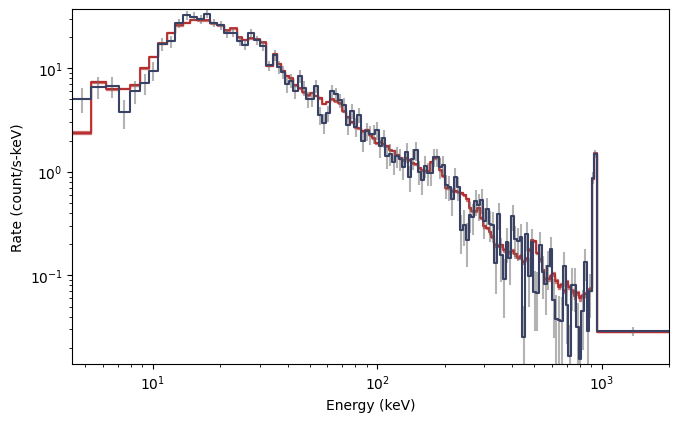

In [3]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

select_time = (150.0, 152.0)

# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*select_time)  # <-- This is what we will use for our simulations

# and the data
spec_data = phaii.to_spectrum(time_range=select_time)

# plot the comparison between the background model and the data
specplot = Spectrum(data=spec_data, background=spec_bkgd)

As you can see, the background model (red) closely follows the background data (blue), so we can consider this an acceptable background model to use for our simulation.  Next, we want to define our source spectrum and exposure:

In [4]:
# Band function with amplitude=0.1, Epeak=300 keV, alpha=-1.0, beta=-2.5
from gbm.spectra.functions import Band
band_params = (0.1, 300.0, -1.0, -2.5)

# 2 s exposure
exposure = 2.0

And finally, we need to decide if our background is to be Poisson or Gaussian generated.  For GBM, it is usually most appropriate to assume it is Gaussian, so that is what we use here.  Now we can create our PHA simulator:

In [5]:
from gbm.simulate import PhaSimulator
pha_sims = PhaSimulator(rsp, Band(), band_params, exposure, spec_bkgd, 'Gaussian')

Alright, the simulator has been initialized.  What now?  Well first, let's look to see how well the simulated background matches our background model:

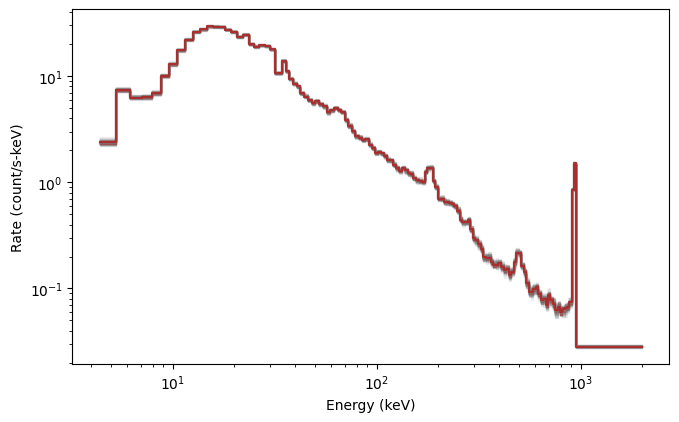

In [6]:
# make 20 simulations of the background
bkgd_devs = pha_sims.simulate_background(20)


# And plot the background model and 20 simulations
# SpectrumBackground is the plotting class for spectral background models
from gbm.plot.gbmplot import SpectrumBackground

specplot = Spectrum()
# background from each simulation
sim_bkgds = [SpectrumBackground(bkgd_dev, specplot.ax, color='gray', alpha=0.1) for bkgd_dev in bkgd_devs]
# our original background model
specplot.set_background(spec_bkgd)

Looks good.  Now let's simulate the background+source, which is essentially what we observe in reality, and compare to just the simulated background:

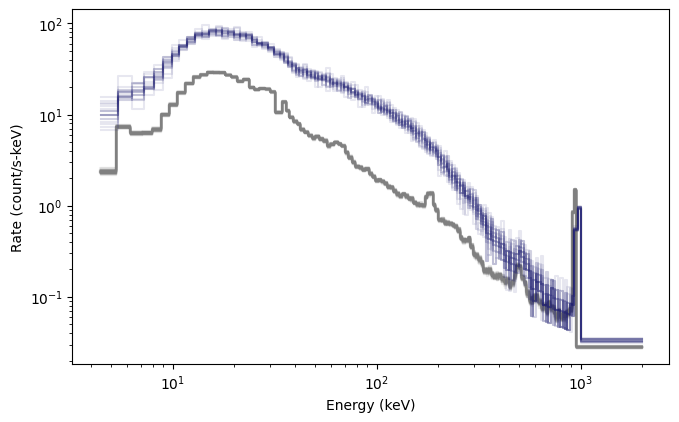

In [7]:
# 20 source+background simulations
summed_devs = pha_sims.simulate_sum(20)

# Histo is the plotting class for observed lightcurves or count spectra
from gbm.plot.gbmplot import Histo

specplot = Spectrum()
# background from each simulation
sim_bkgds = [SpectrumBackground(bkgd_dev, specplot.ax, color='gray', alpha=0.1) for bkgd_dev in bkgd_devs]
# the summed "observed" data from each simulation
sim_signals = [Histo(summed_dev, specplot.ax, color='midnightblue', alpha=0.1) for summed_dev in summed_devs]

Fantastic!  Another cool thing you can do is generate fully formed ``BAK`` and ``PHA`` objects from the simulations:

In [8]:
# create 5 simulated BAK and PHA objects
baks = pha_sims.to_bak(5)
phas = pha_sims.to_pha(5)
print(baks)
print(phas)

[<gbm.data.pha.BAK object at 0x12996d7d0>, <gbm.data.pha.BAK object at 0x1299a3810>, <gbm.data.pha.BAK object at 0x1299c8f50>, <gbm.data.pha.BAK object at 0x1299e38d0>, <gbm.data.pha.BAK object at 0x1299f2310>]
[<gbm.data.pha.PHA object at 0x129a05ed0>, <gbm.data.pha.PHA object at 0x129a0e4d0>, <gbm.data.pha.PHA object at 0x129a18610>, <gbm.data.pha.PHA object at 0x129a2d610>, <gbm.data.pha.PHA object at 0x129a42090>]


Those objects can then be written to disk if desired by the corresponding ``.write()`` methods.  You can also create (and write) a ``PHAII`` object by concatenating all of your simulations into a single time-series:

In [9]:
# concatenate 10 simulations into a single PHAII object
pha_sims.to_phaii(10)

---

## Simulate TTE Data

Simulating PHA data isn't interesting enough, you say?  Well, good news: you can also simulate TTE data.  Specifically, you can simulate a lightcurve with the full spectral resolution of the GBM detector response.  To do that, we'll use the TTE simulators and some time profile functions:

In [10]:
# source and background simulators
from gbm.simulate import TteSourceSimulator, TteBackgroundSimulator

# A tophat (rectangular) pulse and a constant background
from gbm.simulate.profiles import tophat, constant

First, we simulate the source spectrum and time profile:

In [11]:
# amplitude, start and stop times of the tophat pulse
tophat_params = (0.05, 0.0, 2.0)

# initialize simulator with the spectral model and time profile
tte_sim = TteSourceSimulator(rsp, Band(), band_params, tophat, tophat_params)

# time range over which to simulate source
tte_src = tte_sim.to_tte(-5.0, 10.0)

And then we simulate the background:

In [12]:
# use our background model spectrum and scale to 200% of the background amplitude
constant_params = (2.0,)
tte_sim = TteBackgroundSimulator(spec_bkgd, 'Gaussian', constant, constant_params)

# time range over which to simulate background
tte_bkgd = tte_sim.to_tte(-10.0, 10.0)

So now we have simulated data for the source and the background.  We want source+background:

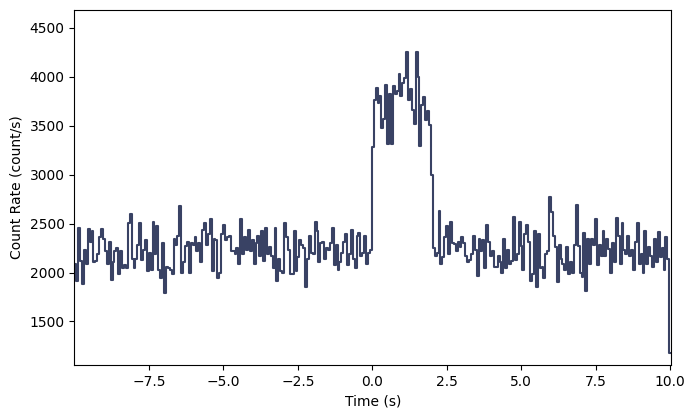

In [13]:
# merge the background and source
tte_total = TTE.merge([tte_bkgd, tte_src])

# bin to 64 ms resolution so we can make a lightcurve plot
phaii = tte_total.to_phaii(bin_by_time, 0.064)
lcplot = Lightcurve(data=phaii.to_lightcurve(energy_range=(8.0, 900.0)))
lcplot.errorbars.hide()

Interesting...but not exactly a realistic looking signal.  Let's try something that looks quite a bit more realistic:

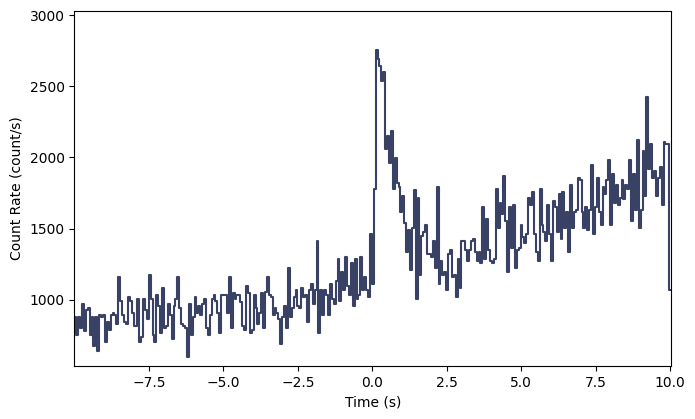

In [14]:
# a Norris pulse shape and a quadratic background
from gbm.simulate.profiles import norris, quadratic

norris_params = (0.05, 0.0, 0.1, 0.5)
quadratic_params = (1.0, 0.05, 0.003)

# source simulation
tte_sim = TteSourceSimulator(rsp, Band(), band_params, norris, norris_params)
tte_src = tte_sim.to_tte(-5.0, 10.0)
                             
# background simulation
tte_sim = TteBackgroundSimulator(spec_bkgd, 'Gaussian', quadratic, quadratic_params)
tte_bkgd = tte_sim.to_tte(-10.0, 10.0)
                                 
# merge the background and source
tte_total = TTE.merge([tte_bkgd, tte_src])

# bin to 64 ms resolution so we can make a lightcurve plot
phaii = tte_total.to_phaii(bin_by_time, 0.064)
lcplot = Lightcurve(data=phaii.to_lightcurve(energy_range=(8.0, 900.0)))
lcplot.errorbars.hide()

Voila!

There are lots of things you can do once you create the simulations; you can essentially treat them like data.
If you're interested in a variety of other aspects of the GBM Data Tools, and a deeper dive under the hood, please [continue on!](./DataPrimitives.ipynb)